# Lesson 7
Rob Lisy

#### Abalone homework
We got some shells, we don't want to hurt the babiez! We should make a model to not hurt the babiez!!!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap # used for feature importance...
import matplotlib.pyplot as plt
shap.initjs()

# sklearn...
from sklearn import svm, metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


shellz = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Abalone.csv'
df = pd.read_csv(shellz)
df.columns = df.columns.str.replace(' ', '_')
df.head()

,Sex,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Find the babiez!

Any shell with <= 11 rings is a [babbit.](https://slate.com/culture/2012/10/the-cloud-atlas-phrasebook-your-guide-to-yibberin-the-true-true-language-of-the-movie.html) We will flag them babbits as such.

# Plottting

There's some relationship (probably!?) between these attributes and the Rings... let's see

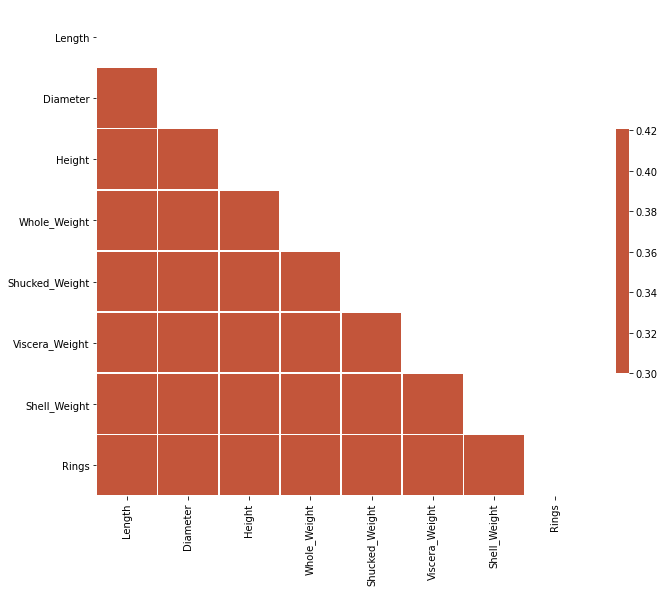

In [2]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});


# Correlation

The correlation looks... not great. No features stand out far above the rest as being correlated with the rings of an abalone. Maybe everything is just multicolinear... like, diameter AND length AND shell weight (etc) are all just fundamentally a function of age (which is the same as rings).

![This is fine.](https://static01.nyt.com/images/2016/08/05/us/05onfire1_xp/05onfire1_xp-superJumbo-v2.jpg)

In [3]:
# Make the target feature
df['Legal_Age'] = df['Rings'].apply(lambda x: 1 if x > 11 else 0)

In [4]:
# Make dummy variables for sex.
df = pd.get_dummies(data=df, columns=['Sex'], prefix='Sex')

df.head()

,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Rings,Legal_Age,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,0,1,0


In [5]:
# Split out into test / train / validate
# 60 / 20 / 20 split for train, test, and validation
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

X_train = train.drop(['Legal_Age', 'Rings'], axis=1)
y_train = train['Legal_Age']
X_test = validate.drop(['Legal_Age', 'Rings'], axis=1)
y_test = validate['Legal_Age']
X_validate = validate.drop(['Legal_Age', 'Rings'], axis=1)
y_validate = validate['Legal_Age']

# Hyperparameters

In [6]:
cost = .9 # penalty parameter of the error term
gamma = 5 # defines the influence of input vectors on the margins

In [7]:
# Test a LinearSVC
clf1 = svm.LinearSVC(C=cost).fit(X_train, y_train)
clf1.predict(X_test)
print("LinearSVC")
print(classification_report(clf1.predict(X_test), y_test))

LinearSVC
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       727
           1       0.40      0.80      0.54       108

    accuracy                           0.82       835
   macro avg       0.68      0.81      0.71       835
weighted avg       0.89      0.82      0.84       835



In [8]:
# Test linear, rbf and poly kernels
for k in ('linear', 'rbf', 'poly'):
    clf = svm.SVC(gamma=gamma, kernel=k, C=cost).fit(X_train, y_train)
    clf.predict(X_test)
    print(k)
    print(classification_report(clf.predict(X_test), y_test))

linear
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       788
           1       0.21      0.94      0.34        47

    accuracy                           0.79       835
   macro avg       0.60      0.86      0.61       835
weighted avg       0.95      0.79      0.85       835

rbf
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       734
           1       0.38      0.80      0.52       101

    accuracy                           0.82       835
   macro avg       0.67      0.81      0.70       835
weighted avg       0.90      0.82      0.84       835

poly
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       717
           1       0.44      0.80      0.57       118

    accuracy                           0.83       835
   macro avg       0.70      0.82      0.73       835
weighted avg       0.89      0.83      0.85       835



# Make an SVM

In [9]:
# To create an example, we're going to use 2 features and make an example SVM
h = .5  # step size in the mesh

# Plotting for confusion matrices...
def plot_cf_matrix(cm):
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show();

def make_svms(X: pd.DataFrame,
             Y: pd.DataFrame,
             cost: float,
             gamma: float):
    """
    Helper function to make a bunch of SVMs using different kernels
    """
    svc = svm.SVC(kernel='linear', C=cost).fit(X, Y)
    rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=cost).fit(X, Y)
    poly_svc = svm.SVC(kernel='poly', gamma=gamma, degree=3, C=cost).fit(X, Y)
    lin_svc = svm.LinearSVC(C=cost).fit(X, Y)
    
    return svc, rbf_svc, poly_svc, lin_svc

In [10]:
def plot_svms(X: pd.DataFrame,
              Y: pd.DataFrame,
              h: float,
              svc: svm.SVC,
              rbf_svc: svm.SVC,
              poly_svc: svm.SVC,
              lin_svc: svm.SVC             
             ):
    # create a mesh to plot in
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # title for the plots
    titles = ['SVC with linear kernel',
              'SVC with RBF kernel',
              'SVC with polynomial kernel',
              'LinearSVC (linear kernel)']

    for i, kernel in enumerate((svc, rbf_svc, poly_svc, lin_svc)):
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        plt.subplot(2, 2, i + 1)
        Z = kernel.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z)
        plt.axis('off')

        # Plot also the training points
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=Y, cmap=plt.cm.Paired)
        plt.title(titles[i])

    plt.show()

In [11]:
# Make our model...
svc, rbf_svc, poly_svc, lin_svc = make_svms(X=X_train, 
                                            Y=y_train,
                                            cost=cost,
                                            gamma=gamma)

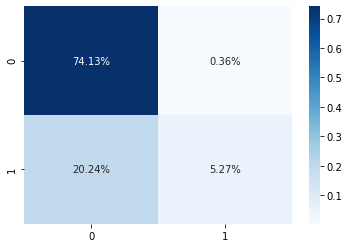

In [12]:
y_pred_test = svc.predict(X_test)
plot_cf_matrix(metrics.confusion_matrix(y_test, y_pred_test))

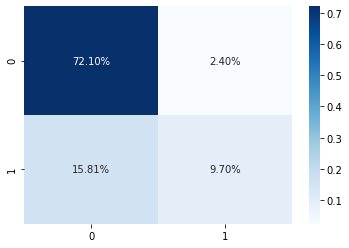

In [13]:
y_pred_test = rbf_svc.predict(X_test)
plot_cf_matrix(metrics.confusion_matrix(y_test, y_pred_test))

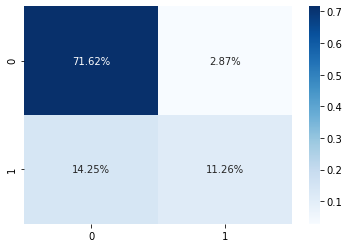

In [14]:
y_pred_test = poly_svc.predict(X_test)
plot_cf_matrix(metrics.confusion_matrix(y_test, y_pred_test))

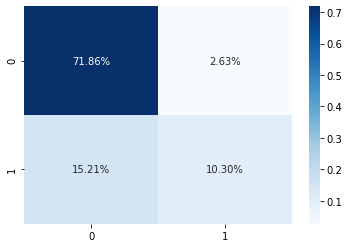

In [15]:
y_pred_test = lin_svc.predict(X_test)
plot_cf_matrix(metrics.confusion_matrix(y_test, y_pred_test))

# Grid search

We chose one set of hyperparameters, now let's go through the entire set of hyperparameters and find the best SVMs.

In [16]:
# Find the best decision tree...

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.387 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.387 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.387 (+/-0.001) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.387 (+/-0.001) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.587 (+/-0.491) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.387 (+/-0.001) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.811 (+/-0.062) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.587 (+/-0.490) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.810 (+/-0.091) for {'C': 1, 'kernel': 'linear'}
0.807 (+/-0.050) for {'C': 10, 'kernel': 'linear'}
0.796 (+/-0.049) for {'C': 100, 'kernel': 'linear'}
0.799 (+/-0.052) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

# Model Choice

Given the state of abalone populations, I want to MINIMIZE mistakenly identifying individuals as being older than they are. This is the false positive rate. So I chose to optimize for precision.

With that in mind, the best model is one with these hyper parameters:
```
Kernel: RBF
Cost: 1000
Gamma: 0.001
```


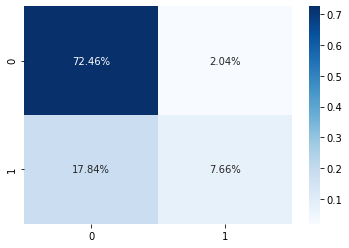

In [18]:
# Performance  
best_model = svm.SVC(kernel='rbf', gamma=.001, C=1000, probability=True).fit(X_train, y_train)
y_pred = best_model.predict(X_test)
plot_cf_matrix(metrics.confusion_matrix(y_test, y_pred))

# Feature Importance

Since the best model is not a linear model, we've hit an unfortunate snag: no linearly displayable explanation of feature importance can be generated for this SVM. THANKFULLY we can [use Shap values](https://github.com/slundberg/shap). They can show the relative feature importance of ANY model. The main draw back here is speed, especially in areas where shap values have not yet been mathmatically optimized (like tree models).

## WARNING!!!
Shap values are a Monte Carlo process that is VERY time consuming. I sample below, but it can still take a while...

In [20]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(best_model.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=20)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Using 2506 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.189e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.103e-04, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.082e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.421e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping 

# Model Performance

We're able to get a false positive rate of ~2%, which should be helpful... since the model is NOT a linear model, I can't get anything like "feature importance" or coefficients for the inputs. I looked at plottting the decision boundaries for a while, but kept getting shape() errors.

# Summary

Would I recommend a model based approach to ablone identification? [No.](https://www.sfchronicle.com/food/article/No-abalone-diving-allowed-in-California-until-2021-13460882.php) I would recommend a pause on collecting them, given that the populations look like they're not doing very well. Potentially trying to farm these animals may be helpful, as we've done with salmon, tilapia, and other seafood stocks.